[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ee-ortiz/ISIS-4825_202510_IMAGENES_Y_VISION/blob/main/Laboratorio_08/MISIS4825_Laboratorio08_Taller.ipynb)

![image](https://drive.google.com/u/0/uc?id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d&export=download)

# Laboratorio 08 – Taller: Redes Neuronales Convolucionales con Modelos Fundacionales

## Introducción

En este taller abordaremos el tema de las redes neuronales convolucionales (CNN) y la aplicación de **modelos fundacionales** mediante *transfer learning*. Para ello, utilizaremos el conjunto de datos **drone-bird classification** de Kaggle.

El objetivo es comparar el rendimiento de un modelo CNN entrenado desde cero con el de un modelo fundacional (por ejemplo, VGG16) adaptado a nuestra tarea de **clasificación de Drones y aves**.

## Objetivos

1. **Entrenar un modelo CNN desde cero** utilizando Keras y TensorFlow.
2. **Aplicar transfer learning** con un modelo fundacional, aprovechando características previamente aprendidas en conjuntos de datos masivos.
3. **Comparar** el rendimiento y la eficiencia de ambos enfoques.
4. **Experimentar** con distintos modelos fundacionales y diferentes configuraciones de hiperparámetros.


**Datos:** [drone-bird classification](https://www.kaggle.com/datasets/preetpalsingh25/alzheimers-dataset-4-class-of-images)

## 1. Descarga y Preparación del Dataset de Kaggle

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('imbikramsaha/drone-bird-classification', path='data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/imbikramsaha/drone-bird-classification


## 2. Exploración de Datos

Vamos a inspeccionar la carpeta que contiene las imágenes de drones y aves y crear un DataFrame con la ruta de cada imagen y su etiqueta. Luego, mostraremos cada una de las categorías y un breve conteo de cuántas imágenes hay por categoría.

Total de imágenes: 324

Número de imágenes por categoría:
label
birds     164
drones    160
Name: count, dtype: int64


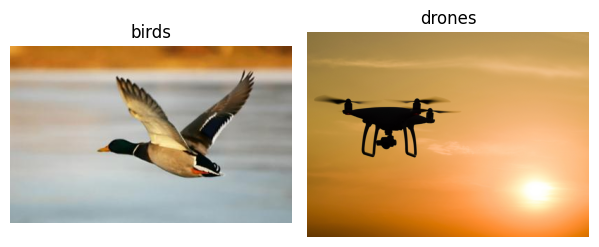

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Directorio base que contiene las carpetas 'train' y 'test'
base_dir = 'data/drone_or_bird'

filepaths = []
labels = []

# Recorrer las carpetas 'train' y 'test'
for label in os.listdir(base_dir):
    label_path = os.path.join(base_dir, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            ext = os.path.splitext(file)[1].lower()
            if ext in ['.png', '.jpg', '.jpeg']:
                filepaths.append(os.path.join(label_path, file))
                labels.append(label)

# Crear DataFrame con las rutas y etiquetas
data_df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Mostrar conteo total y por categoría
print("Total de imágenes:", len(data_df))
print("\nNúmero de imágenes por categoría:")
print(data_df['label'].value_counts())

# Mostrar una imagen por categoría
categorias = data_df['label'].unique()
num_muestras = len(categorias)

plt.figure(figsize=(15, 10))
for i, categoria in enumerate(categorias[:num_muestras]):
    img_path = data_df[data_df['label'] == categoria].iloc[0]['filepath']
    img = mpimg.imread(img_path)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{categoria}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 3. Preprocesamiento de Datos

Dividimos el dataset completo en tres conjuntos:
- **Entrenamiento (70%)**
- **Validación (20%)**
- **Prueba (10%)**

Esta separación nos permitirá evaluar la capacidad de generalización de nuestros modelos.

In [3]:
from sklearn.model_selection import train_test_split

# Dividir el dataset en 70% entrenamiento y 30% (validación + prueba)
train_df, test_val_df = train_test_split(
    data_df, test_size=0.3, random_state=42, stratify=data_df['label']
)

# A partir del 30% restante, dividir en 2/3 para validación y 1/3 para prueba (~20% y ~10% del total, respectivamente)
val_df, test_df = train_test_split(
    test_val_df, test_size=(1/3), random_state=42, stratify=test_val_df['label']
)

print("Entrenamiento:", len(train_df))
print("Validación:", len(val_df))
print("Prueba:", len(test_df))


Entrenamiento: 226
Validación: 65
Prueba: 33


## 4. Generadores de Imágenes

Utilizaremos la clase `ImageDataGenerator` de Keras para:
- Reescalar los valores de píxel al rango [0, 1].
- Aplicar data augmentation (rotación, volteo horizontal) en el conjunto de entrenamiento.
- Mantener intactos los conjuntos de validación y prueba (solo reescalado).

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True
)

test_val_datagen = ImageDataGenerator(
    rescale=1./255
)

img_size = (128, 128)  # Compatible con la mayoría de modelos fundacionales
batch_size = 32

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=img_size, batch_size=batch_size,
    class_mode='categorical'
)

val_gen = test_val_datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label',
    target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

test_gen = test_val_datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label',
    target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

# Diccionario con nombre de clase -> índice
labels_map = train_gen.class_indices

# Invertimos el diccionario para tener índice -> nombre de clase
idx_to_class = {v: k for k, v in labels_map.items()}

print("\nCategorías reconocidas:")
for idx in sorted(idx_to_class):
    print(f"  Clase {idx}: '{idx_to_class[idx]}'")

num_classes = len(labels_map)
print("Número de clases:", num_classes)

2025-05-01 13:52:11.643042: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-01 13:52:12.173050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746125532.356170   13550 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746125532.407799   13550 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746125532.833936   13550 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Found 226 validated image filenames belonging to 2 classes.
Found 65 validated image filenames belonging to 2 classes.
Found 33 validated image filenames belonging to 2 classes.

Categorías reconocidas:
  Clase 0: 'birds'
  Clase 1: 'drones'
Número de clases: 2


## 5. Construcción del Modelo de Red Convolucional

En esta sección, definiremos una CNN desde cero (modelo *scratch*) para la clasificación de fracturas. Este modelo tendrá varias capas convolucionales y capas de pooling, seguido de capas densas para la clasificación.


In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_scratch = Sequential([
    # Primer bloque convolucional
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    # Segundo bloque
    Conv2D(64, (3,3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    # Tercer bloque
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    # Aplanamiento y capas densas
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model_scratch.summary()

/home/pukini/.pyenv/versions/3.12.9/envs/iv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746125548.815848   13550 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2142 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     5,538,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,677,986 (21.66 MB)

 Trainable params: 5,677,986 (21.66 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Definición de Callbacks

Utilizamos *ModelCheckpoint* para guardar la mejor versión del modelo, *EarlyStopping* para detener el entrenamiento cuando la métrica de validación deje de mejorar y *ReduceLROnPlateau* para ajustar dinámicamente la tasa de aprendizaje.

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model_scratch.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_scratch = [
    ModelCheckpoint('best_model_scratch.keras', save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')
]

## 7. Entrenamiento del Modelo

Entrenamos la red desde cero con los parámetros definidos anteriormente.  

In [7]:
import tensorflow as tf

epochs_scratch = 15
with tf.device('/device:GPU:0'):
    history_scratch = model_scratch.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs_scratch,
        callbacks=callbacks_scratch
    )

/home/pukini/.pyenv/versions/3.12.9/envs/iv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1746125557.342500   16014 service.cc:152] XLA service 0x71652800f8a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746125557.342515   16014 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-05-01 13:52:37.411542: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746125557.714825   16014 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/8 ━━━━━━━━━━━━━━━━━━━━ 1:01 9s/step - accuracy: 0.5938 - loss: 0.6889

I0000 00:00:1746125564.297585   16014 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.4799 - loss: 0.8789

2025-05-01 13:52:49.275713: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 4 bytes spill stores, 4 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4796 - loss: 0.8747 - val_accuracy: 0.4769 - val_loss: 0.6926 - learning_rate: 0.0010
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 391ms/step - accuracy: 0.5381 - loss: 0.6897 - val_accuracy: 0.5231 - val_loss: 0.6869 - learning_rate: 0.0010
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.4689 - loss: 0.6919 - val_accuracy: 0.5385 - val_loss: 0.6833 - learning_rate: 0.0010
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - accuracy: 0.5339 - loss: 0.6860 - val_accuracy: 0.5077 - val_loss: 0.7027 - learning_rate: 0.0010
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.6111 - loss: 0.6510 - val_accuracy: 0.5077 - val_loss: 0.7395 - learning_rate: 0.0010
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step - accuracy: 0.5020 - loss: 0.7025 - val_accuracy: 0.5846 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - accuracy: 0.5989 - loss: 0.6742 - val_accuracy: 0.6154 - val_

## 8. Evaluación del Modelo

Visualizaremos las curvas de entrenamiento (precisión y pérdida) y cargaremos la mejor versión del modelo para evaluar en el conjunto de prueba.

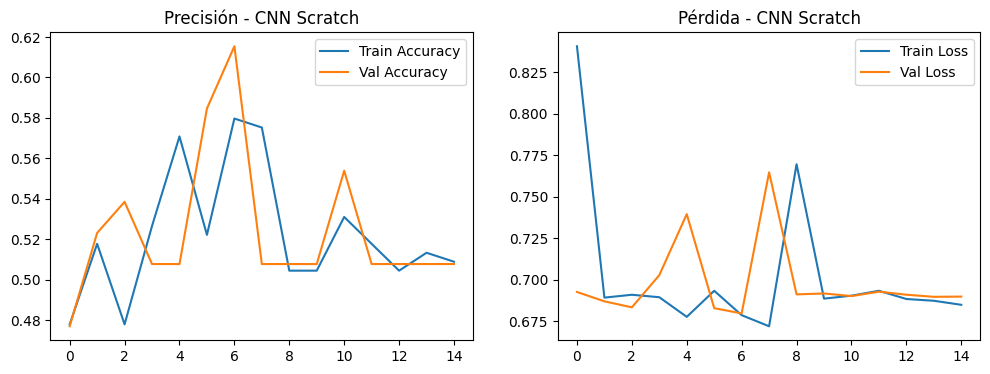

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


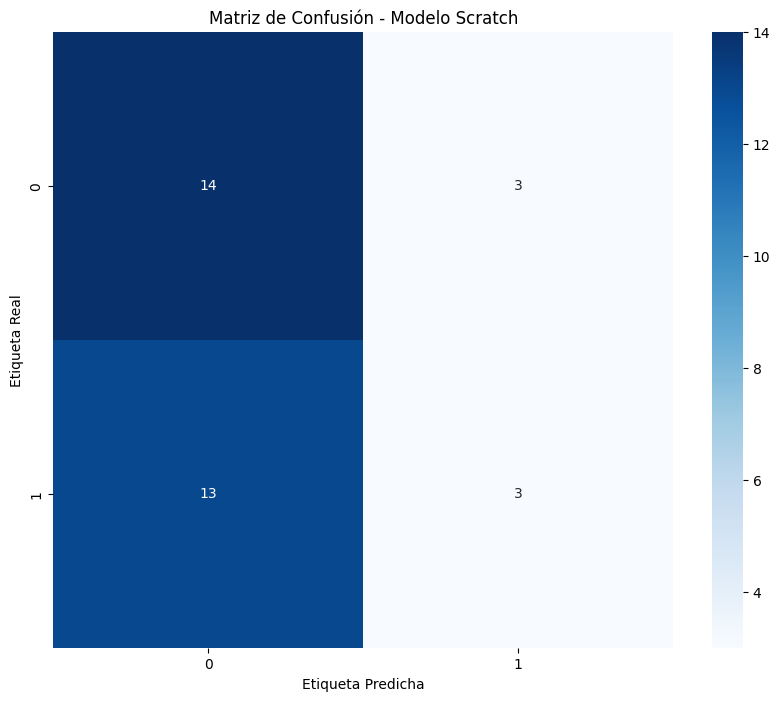

Reporte de Clasificación - Modelo Scratch

              precision    recall  f1-score   support

       birds       0.52      0.82      0.64        17
      drones       0.50      0.19      0.27        16

    accuracy                           0.52        33
   macro avg       0.51      0.51      0.45        33
weighted avg       0.51      0.52      0.46        33



In [8]:
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Graficar la historia de entrenamiento
acc = history_scratch.history['accuracy']
val_acc = history_scratch.history['val_accuracy']
loss = history_scratch.history['loss']
val_loss = history_scratch.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Precisión - CNN Scratch')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Pérdida - CNN Scratch')
plt.show()

# Cargar el mejor modelo y evaluar
best_scratch_model = load_model('best_model_scratch.keras')
test_gen.reset()
preds_scratch = best_scratch_model.predict(test_gen, verbose=1)
y_pred_scratch = np.argmax(preds_scratch, axis=1)
y_true = test_gen.classes

cm_scratch = confusion_matrix(y_true, y_pred_scratch)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_scratch, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - Modelo Scratch')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

print("Reporte de Clasificación - Modelo Scratch")
print()
print(classification_report(y_true, y_pred_scratch, target_names=labels_map, zero_division=0))

## 9. Transfer Learning con Modelos Fundacionales

En esta sección se aprovechará el poder de un modelo pre-entrenado, en concreto **VGG16**, para aplicar *transfer learning* en nuestra tarea de clasificación de imágenes. Utilizar un modelo como VGG16 permite:
  
- **Reducción en el tiempo de entrenamiento:** El modelo base ya ha sido entrenado en un conjunto masivo (ImageNet), lo que significa que las capas iniciales han aprendido a extraer características generales muy útiles.
- **Mejor rendimiento en datasets limitados:** Al reutilizar las representaciones aprendidas, se pueden obtener resultados competitivos incluso cuando el conjunto de datos de destino es relativamente pequeño.
  
### Sobre VGG16

VGG16 fue desarrollado por Simonyan y Zisserman en su artículo *"Very Deep Convolutional Networks for Large-Scale Image Recognition"* ([ver paper](https://arxiv.org/abs/1409.1556)). Algunas de sus características destacadas son:

- **Filtros uniformes:** Emplea filtros uniformes de 3x3 a lo largo de toda la arquitectura, lo que facilita la extracción sistemática de patrones jerárquicos a distintos niveles de abstracción.
- **Estructura profunda:** Consta de 16 capas con pesos (13 capas convolucionales y 3 capas densas), lo que permite una representación rica y detallada de las imágenes.
- **Simplicidad en el diseño:** A pesar de su profundidad, utiliza únicamente capas convolucionales con pequeños filtros y capas de pooling, lo que resulta en una arquitectura elegante y uniforme.

A continuación, se muestra un diagrama ilustrativo de la arquitectura VGG16:

![Arquitectura VGG16](https://miro.medium.com/v2/resize:fit:720/1*lXCy8RLUOtAwoS2H4ortZA.png)


### Implementación con VGG16

El siguiente bloque de código carga VGG16 sin la parte superior (la capa de clasificación final), congela sus capas para evitar su reentrenamiento, y añade una parte superior que se adapta a nuestro problema. Se entrena el modelo y se guardan las mejores versiones según la métrica de validación.

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Cargar VGG16 pre-entrenado en ImageNet, sin incluir la parte superior
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Congelar todas las capas del modelo base para no reentrenarlas
for layer in base_model_vgg.layers:
    layer.trainable = False

# Construir el modelo de transfer learning
model_vgg = Sequential([
    base_model_vgg,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# Mostrar la arquitectura del modelo
model_vgg.summary()

# Compilar el modelo
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Definir callbacks para guardar el mejor modelo, detener tempranamente y reducir la tasa de aprendizaje
callbacks_vgg = [
    ModelCheckpoint('best_model_vgg.keras', save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')
]

# Entrenar el modelo de transfer learning
epochs_vgg = 15
with tf.device('/device:GPU:0'):
    history_vgg = model_vgg.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs_vgg,
        callbacks=callbacks_vgg
    )

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,610 (56.38 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/15


2025-05-01 13:53:42.835095: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_921', 188 bytes spill stores, 188 bytes spill loads

2025-05-01 13:53:43.668533: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1413', 56 bytes spill stores, 56 bytes spill loads

2025-05-01 13:53:43.740770: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1413', 32 bytes spill stores, 32 bytes spill loads



6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.5588 - loss: 0.6749

2025-05-01 13:53:50.959739: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_921', 96 bytes spill stores, 96 bytes spill loads



7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.5629 - loss: 0.6709

2025-05-01 13:53:54.168293: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_234', 4 bytes spill stores, 4 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5666 - loss: 0.6660 - val_accuracy: 0.8308 - val_loss: 0.5282 - learning_rate: 0.0010
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - accuracy: 0.7200 - loss: 0.5809 - val_accuracy: 0.8615 - val_loss: 0.4646 - learning_rate: 0.0010
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/step - accuracy: 0.8049 - loss: 0.4677 - val_accuracy: 0.7846 - val_loss: 0.4114 - learning_rate: 0.0010
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 328ms/step - accuracy: 0.8043 - loss: 0.4458 - val_accuracy: 0.8308 - val_loss: 0.3781 - learning_rate: 0.0010
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step - accuracy: 0.7949 - loss: 0.4618 - val_accuracy: 0.8462 - val_loss: 0.3490 - learning_rate: 0.0010
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step - accuracy: 0.8532 - loss: 0.3497 - val_accuracy: 0.8923 - val_loss: 0.3106 - learning_rate: 0.0010
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - accuracy: 0.8758 - loss: 0.3380 - val_accuracy: 0.8769 - val_

### Evaluación del Modelo

Visualizaremos las curvas de entrenamiento y evaluaremos la mejor versión del modelo en el conjunto de prueba.

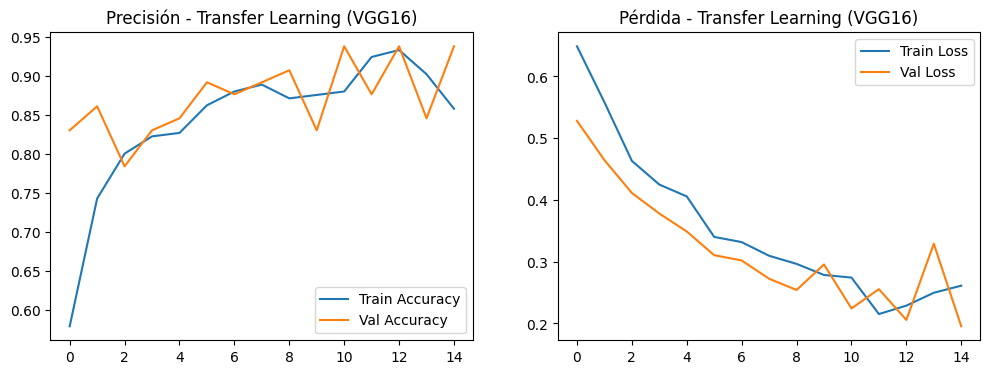

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 521ms/step


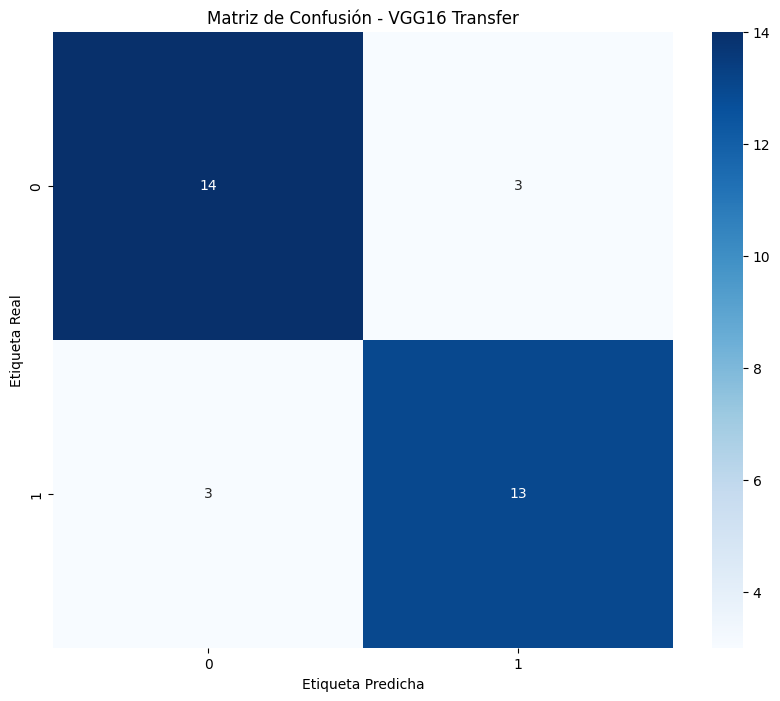

Reporte de Clasificación - Transfer Learning (VGG16)

              precision    recall  f1-score   support

       birds       0.82      0.82      0.82        17
      drones       0.81      0.81      0.81        16

    accuracy                           0.82        33
   macro avg       0.82      0.82      0.82        33
weighted avg       0.82      0.82      0.82        33



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Graficar la historia de entrenamiento
acc_vgg = history_vgg.history['accuracy']
val_acc_vgg = history_vgg.history['val_accuracy']
loss_vgg = history_vgg.history['loss']
val_loss_vgg = history_vgg.history['val_loss']
epochs_range_vgg = range(len(acc_vgg))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_vgg, acc_vgg, label='Train Accuracy')
plt.plot(epochs_range_vgg, val_acc_vgg, label='Val Accuracy')
plt.legend()
plt.title('Precisión - Transfer Learning (VGG16)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_vgg, loss_vgg, label='Train Loss')
plt.plot(epochs_range_vgg, val_loss_vgg, label='Val Loss')
plt.legend()
plt.title('Pérdida - Transfer Learning (VGG16)')
plt.show()

# Cargar el mejor modelo y evaluar
best_vgg_model = load_model('best_model_vgg.keras')
test_gen.reset()
preds_vgg = best_vgg_model.predict(test_gen, verbose=1)
y_pred_vgg = np.argmax(preds_vgg, axis=1)

cm_vgg = confusion_matrix(y_true, y_pred_vgg)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - VGG16 Transfer')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

print("Reporte de Clasificación - Transfer Learning (VGG16)")
print()
print(classification_report(y_true, y_pred_vgg, target_names=labels_map, zero_division=0))

## 10. Conclusiones y Discusión

- **Comparación entre modelo Scratch y el modelo VGG16:**  
  - ¿Cuál obtuvo mejor precisión y cuál converge más rápido?
  - ¿Fue necesario más tiempo para entrenar la red desde cero?
  - ¿Por qué la arquitectura pre-entrenada podría ofrecer ventajas cuando el dataset de destino no es enorme?

- **Experimentación con Otros Modelos Fundacionales:**  
  1. Probar otras arquitecturas, como SqueezeNet, MobileNetV2, ResNet50, InceptionV3 o cualquiera de su elección.
  2. Ajustar hiperparámetros (tasa de aprendizaje, batch size, número de capas entrenables, etc.).
  3. Comparar los resultados y analizar por qué ciertos modelos pueden resultar más efectivos en este tipo de problema.

# **Integrantes**
- Nicolas Ruiz Perez - 202123608
- Valeria Caro Ramirez - 202111040

## **Comparación entre modelo Scratch y el modelo VGG16**

- **¿Cuál obtuvo mejor precisión y cuál converge más rápido?**

     * **Mejor precisión**: El modelo VGG16 alcanzó una precisión promedio del 82%, superando significativamente al modelo Scratch, que obtuvo solo un 51%. Esto evidencia que el modelo preentrenado generaliza mejor al aprovechar características previamente aprendidas. Además, el modelo VGG16 muestra un desempeño más equilibrado, ya que sus métricas (precisión, recall y F1-score) son consistentes entre las clases, lo que indica una mayor estabilidad en la clasificación.
              

    * **Convergencia**: El modelo VGG16 converge más rápido debido a que reutiliza características preentrenadas, mientras que el modelo Scratch necesita aprender desde cero.


     * **Tabla de resultados**:
          - Birds: El modelo VGG16 muestra un desempeño significativamente mejor y equilibrado en todas las métricas en comparación con el modelo Scratch.
          - Drones: El modelo Scratch tiene un desempeño muy bajo en recall y F1-score, mientras que el modelo VGG16 mantiene métricas consistentes y altas.
     
               | **Clase**   | **Métrica**   | **Modelo Scratch** | **Modelo VGG16** |
               |-------------|---------------|---------------------|------------------|
               | **Birds**   | **Precisión** | 52%                | 82%             |
               |             | **Recall**    | 82%                | 82%             |
               |             | **F1-Score**  | 64%                | 82%             |
               | **Drones**  | **Precisión** | 50%                | 81%             |
               |             | **Recall**    | 19%                | 81%             |
               |             | **F1-Score**  | 27%                | 81%             |
    
          
          


- **¿Fue necesario más tiempo para entrenar la red desde cero?**

    - Sí, el modelo Scratch requiere más tiempo de entrenamiento porque debe ajustar todos los pesos desde cero, mientras que el modelo VGG16 solo entrena las capas superiores, lo que reduce significativamente el tiempo de entrenamiento.

- **¿Por qué la arquitectura preentrenada podría ofrecer ventajas cuando el dataset de destino no es enorme?**

    - **Características Generales Aprendidas**: El modelo VGG16 ha sido previamente entrenado en un conjunto de datos masivo como ImageNet, lo que le permite extraer características generales y robustas. Estas características pueden ser reutilizadas y adaptadas eficientemente a tareas específicas, incluso cuando el dataset de destino es limitado en tamaño.

    - **Reducción del Riesgo de Sobreajuste**: Al congelar las capas inferiores del modelo preentrenado, se evita que el modelo ajuste excesivamente los pesos a los datos del conjunto pequeño, lo que reduce significativamente el riesgo de sobreajuste y mejora la capacidad de generalización.

    - **Eficiencia en Recursos y Tiempo**: Los modelos preentrenados requieren menos datos y tiempo para alcanzar un rendimiento competitivo, ya que solo es necesario entrenar las capas superiores específicas de la tarea. Esto resulta en un proceso de entrenamiento más eficiente y rápido en comparación con entrenar un modelo desde cero.

## **Experimentación con Otros Modelos Fundacionales:**  